In [1]:
import sys
sys.path.append('./../../designer/script/')
sys.path.append('./../')
sys.path.append('./../../')

import film as film_mod
import design as design_mod
import spectrum as spec_mod
from optimizer.adam import AdamThicknessOptimizer

from analyze_utils.make_design import make_reflection_design

import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy



ImportError: cannot import name 'NDArray' from 'numpy.typing' (C:\Users\rfeng6\AppData\Roaming\Python\Python39\site-packages\numpy\typing\__init__.py)

## Different Batch Size

In [ ]:
def make_rand_new_film():
    d = np.random.random(200) * 10 # smaller ot allows for fewer configurations
    film = film_mod.TwoMaterialFilm('SiO2', 'TiO2', 'SiO2', d)
    return film

design = make_reflection_design(make_rand_new_film())
target: list[spec_mod.BaseSpectrum] = design.target_specs

rep = 10
batches = [50, 100, 500]

loss_rep_ls = []
film_rep_ls = []
for _ in range(rep):
    loss_ls = []
    film_ls = []

    for wl_batch in batches:
        losses, films = adam_optimize(
            make_rand_new_film(), 
            target, 
            1000, 
            alpha=1, 
            batch_size_wl=wl_batch, 
            show=False, 
            record=True, 
        )
        loss_ls.append(losses)
        film_ls.append(films)
    loss_rep_ls.append(loss_ls)
    film_rep_ls.append(film_ls)

working_file = './batches'
# with open(working_file, 'wb') as file:
#     pickle.dump({'batches': batches, 'film': film_rep_ls, 'loss': loss_rep_ls}, file)

In [255]:
working_file = './raw_result/batches_small_ot'

with open(working_file, 'rb') as file:
    d = pickle.load(file)
    film_rep_ls = d['film']
    loss_rep_ls = d['loss']
print('loaded')


loaded


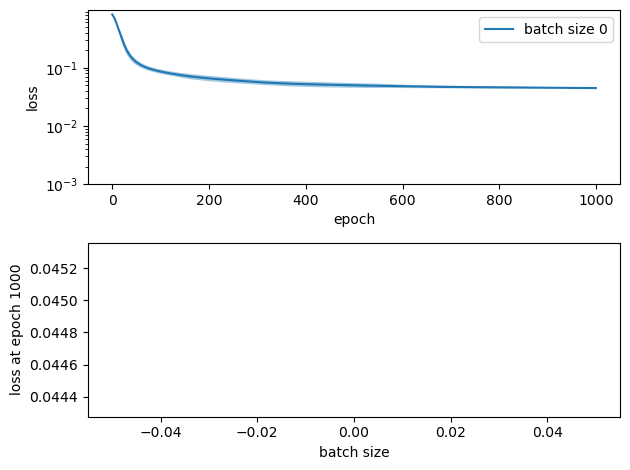

In [257]:
fig, (ax1, ax2) = plt.subplots(2, 1)
loss_rep_ls = np.array(loss_rep_ls)
loss_ls = loss_rep_ls.mean(axis=0)
loss_std_ls = loss_rep_ls.std(axis=0)
for losses, loss_std, batch_size in zip(loss_ls, loss_std_ls, batches):
    ax1.plot(losses, label=f'batch size {batch_size}')
    ax1.fill_between(range(len(losses)), losses - loss_std, losses + loss_std, alpha=0.4)
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.set_yscale('log')
ax1.set_ylim(1e-3, None)
ax1.legend()

last_loss = np.array([s[-1] for s in loss_ls])
last_std = np.array([s[-1] for s in loss_std_ls])
ax2.plot(batches, last_loss)
ax2.fill_between(batches, last_loss - last_std, last_loss + last_std, alpha=0.4)
ax2.set_xlabel('batch size')
ax2.set_ylabel(f'loss at epoch {len(loss_ls[0])}')

fig.tight_layout()

Text(0.5, 1.0, 'loss: 0.04464590486638516')

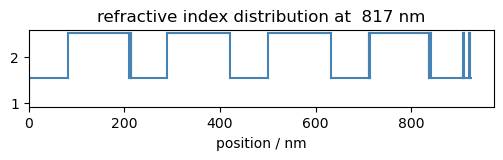

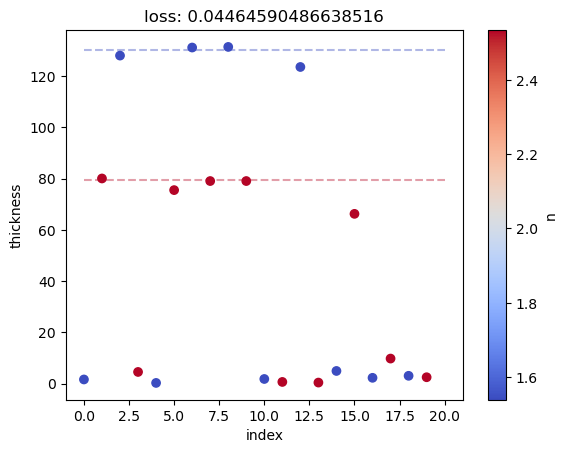

In [260]:
from analyze_utils.structure import plot_layer_thickness
from utils.loss import calculate_RMS_f_spec, calculate_RMS
from utils.get_n import get_n_SiO2, get_n_TiO2
import matplotlib.cm as cmap

def plot_thickness_idx(f):
    d = f.get_d()
    fig, ax = plt.subplots(1, 1)
    wl = np.array([750.])
    s = ax.scatter(range(d.shape[0]), d, marker='o', cmap='coolwarm', c=f.calculate_n_array(wl)[0, :])
    cbar = fig.colorbar(s)
    cbar.set_label('n')

    # target: 800 nm DBR
    wl = 800.
    d_SiO2 = wl / 4 / get_n_SiO2(wl)
    d_TiO2 = wl / 4 / get_n_TiO2(wl)
    
    ax.plot([0, d.shape[0]], [d_SiO2, d_SiO2], c=cmap.get_cmap('coolwarm')(0), alpha=0.4, ls='--')
    ax.plot([0, d.shape[0]], [d_TiO2, d_TiO2], c=cmap.get_cmap('coolwarm')(0.99), alpha=0.4, ls='--')
    ax.set_xlabel('index')
    ax.set_ylabel('thickness')
    return fig, ax

f: film_mod.TwoMaterialFilm = film_rep_ls[6][0][-1] # 5, 19, 50, 64, 68, 89
f.add_spec_param(target[0].INC_ANG, target[0].WLS)
f.remove_negative_thickness_layer()

plot_layer_thickness(f)
_, ax = plot_thickness_idx(f)
ax.set_title(f'loss: {calculate_RMS_f_spec(f, target)}')

## Different OT - Bragg structure

In [301]:
def make_rand_new_film_dif_gt(gt):
    layers = 200
    d = np.random.random(layers) * gt / layers * 2 # smaller ot allows for fewer configurations
    film = film_mod.TwoMaterialFilm('SiO2', 'TiO2', 'SiO2', d)
    return film

design = make_reflection_design(make_rand_new_film_dif_gt(0))
target: list[spec_mod.BaseSpectrum] = design.target_specs

rep = 50
gts = np.linspace(200, 5000, 20)
loss_rep_ls = []
film_rep_ls = []
for rep_i in range(rep):
    loss_ls = []
    film_ls = []
    print(rep_i / rep)
    for gt in gts:
        losses, films = adam_optimize(
            make_rand_new_film_dif_gt(gt), 
            target, 
            500, 
            alpha=1, 
            show=False, 
            record=True, 
        )
        loss_ls.append(losses)
        film_ls.append(films)
    loss_rep_ls.append(loss_ls)
    film_rep_ls.append(film_ls)

working_file = './gts'
with open(working_file, 'wb') as file:
    pickle.dump({'film': film_rep_ls, 'loss': loss_rep_ls}, file)

0.08
convergent, terminate eraly
0.1
convergent, terminate eraly
convergent, terminate eraly
0.12
convergent, terminate eraly
0.14
convergent, terminate eraly
convergent, terminate eraly
0.16
convergent, terminate eraly
convergent, terminate eraly
0.18
convergent, terminate eraly
0.2
convergent, terminate eraly
0.22
convergent, terminate eraly
0.24
convergent, terminate eraly
convergent, terminate eraly
0.26
convergent, terminate eraly
0.28
convergent, terminate eraly
convergent, terminate eraly
0.3
convergent, terminate eraly
convergent, terminate eraly
0.32
convergent, terminate eraly
0.34
convergent, terminate eraly
0.36
0.38
convergent, terminate eraly
0.4
convergent, terminate eraly
0.42
convergent, terminate eraly
0.44
convergent, terminate eraly
0.46
0.48
convergent, terminate eraly
convergent, terminate eraly
0.5
convergent, terminate eraly
0.52
convergent, terminate eraly
convergent, terminate eraly
0.54
convergent, terminate eraly
convergent, terminate eraly
0.56
convergent, 

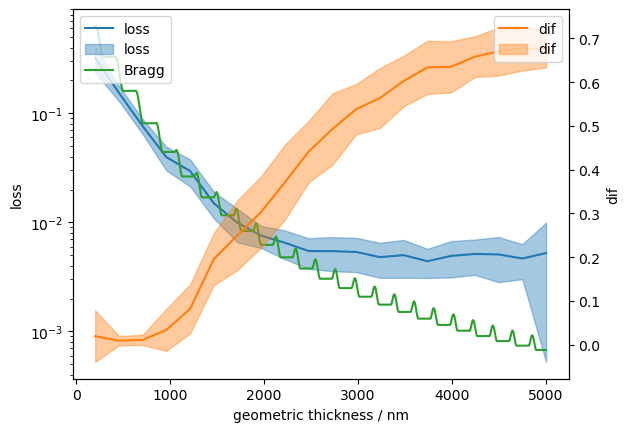

In [316]:

def calculate_dif_Bragg(film: film_mod.TwoMaterialFilm, dA, dB):
    # NOTE: film keeps the material of the first layer in remove negative layers.
    # The first layer is SiO2.
    d = film.get_d()
    dif = 0
    for i, di in enumerate(d):
        dif += min(abs(di - [dA, dB][i % 2]), abs(di - 0))
    return dif / d.sum()

def plot_rep(ax, x, arr, label):
    arr_mean = arr.mean(axis=0)
    arr_std = arr.std(axis=0)
    
    c = next(c_gen)
    ax.plot(x, arr_mean, label=label, c=c)
    ax.fill_between(x, arr_mean - arr_std, arr_mean + arr_std, label=label, alpha=0.4, color=c)
    return ax

# make reference: DBR
def loss_DBR(gt):
    d_tot = 0
    i = 0
    while True:
        this_d = [d_TiO2, d_SiO2][i % 2]
        d_tot += this_d
        if d_tot > gt:
            break
        i += 1
    last_d = this_d - (d_tot - gt)
    d = np.array([d_TiO2, d_SiO2] * (i // 2) + [d_TiO2] * (i % 2) + [last_d])
    film = film_mod.TwoMaterialFilm('TiO2', 'SiO2', 'SiO2', d)
    return calculate_RMS_f_spec(film, target)

def color():
    i = 0
    while True:
        yield f'C{i}'
        i += 1




loss_rep_arr = np.array([[l[-1] for l in rep] for rep in loss_rep_ls])

wl = 800.
d_SiO2 = wl / 4 / get_n_SiO2(wl)
d_TiO2 = wl / 4 / get_n_TiO2(wl)

dif = []
for films in film_rep_ls:
    dif.append([])
    for film in [f[-1] for f in films]:
        film.remove_negative_thickness_layer()
        # plot_thickness_idx(film)
        # print(calculate_RMS_f_spec(film, target))

        dif[-1].append(calculate_dif_Bragg(film, d_SiO2, d_TiO2))
dif = np.array(dif)

c_gen = color()
fig, ax = plt.subplots(1, 1)
plot_rep(ax, gts, loss_rep_arr, 'loss')
gts_dense = np.linspace(gts[0], gts[-1], 1000)
ax.plot(gts_dense, [loss_DBR(gt) for gt in gts_dense], label='Bragg', c='C2')
ax.set_ylabel('loss')
ax.legend(loc='upper left')
ax.set_xlabel('geometric thickness / nm')
ax.set_yscale('log')

ax2 = plot_rep(ax.twinx(), gts, dif, 'dif')
ax2.set_ylabel('dif')
ax2.legend(loc='upper right')
# ax2.set_yscale('log')
